In [ ]:
# Bibliotecas para manipulação de dados
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Modelagem e validação
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer

# Bibliotecas de visualização
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Carrega os conjuntos de treino e teste
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print("Dataset de treino:", train.shape)
print("Dataset de teste:", test.shape)

# Verifica a distribuição das classes 
print("\nDistribuição da variável alvo:")
print(train['labels'].value_counts())
print(train['labels'].value_counts(normalize=True))

train.head()


Dataset de treino: (646, 33)
Dataset de teste: (277, 32)

Distribuição da variável alvo:
labels
1    418
0    228
Name: count, dtype: int64
labels
1    0.647059
0    0.352941
Name: proportion, dtype: float64


,id,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,labels
0,719,10.42,13.09,8.98,12.72,4,3,4087500,3,1,...,0,0,1,1,0,0,0,0,1.0,0
1,429,3.79,3.79,NaN,NaN,21,1,45000000,0,0,...,0,0,0,0,0,1,0,0,1.0,1
2,178,0.71,2.28,1.95,2.28,5,2,5200000,2,1,...,0,1,1,0,1,0,0,0,1.0,0
3,197,3.00,5.00,9.62,10.39,16,2,14500000,2,0,...,0,0,0,1,0,1,0,0,2.0,1
4,444,0.66,5.88,6.21,8.61,29,5,70000000,4,1,...,0,0,0,0,1,1,1,1,2.8,1


## Tratamento de Variáveis Categóricas

A variável `category_code` foi analisada e removida do dataset por apresentar:
- Alta cardinalidade (muitas categorias únicas)
- Baixa correlação com o target
- Risco de overfitting ao criar muitas variáveis dummy


Valores ausentes por coluna:
                     Coluna  Ausentes  Percentual
3  age_first_milestone_year       138       21.36
4   age_last_milestone_year       111       17.18
1    age_first_funding_year        35        5.42
2     age_last_funding_year         9        1.39


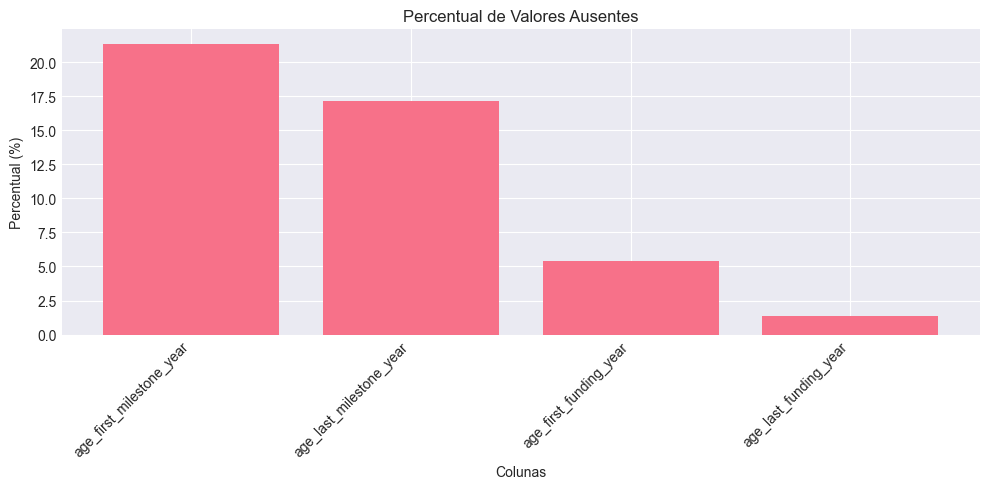


Estratégia de tratamento: Imputação pela mediana


In [ ]:
# Identifica as colunas com valores ausentes
missing = train.isnull().sum()
missing_pct = (missing / len(train) * 100).round(2)

missing_df = pd.DataFrame({
    'Coluna': missing.index,
    'Ausentes': missing.values,
    'Percentual': missing_pct.values
})

# Filtra apenas colunas com valores ausentes
missing_df = missing_df[missing_df['Ausentes'] > 0].sort_values('Ausentes', ascending=False)

print("Valores ausentes por coluna:")
print(missing_df)

# Visualiza o percentual de valores ausentes
plt.figure(figsize=(10, 5))
plt.bar(missing_df['Coluna'], missing_df['Percentual'])
plt.title('Percentual de Valores Ausentes')
plt.xlabel('Colunas')
plt.ylabel('Percentual (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nEstratégia de tratamento: Imputação pela mediana")


Top 15 correlações com sucesso:
relationships               0.342841
milestones                  0.335149
age_last_milestone_year     0.257261
has_roundB                  0.214299
funding_rounds              0.212760
avg_participants            0.194482
has_roundC                  0.172943
has_roundA                  0.171953
has_roundD                  0.166680
age_first_milestone_year    0.156837
is_MA                       0.116638
is_CA                       0.101427
age_last_funding_year       0.074744
is_enterprise               0.067350
funding_total_usd           0.043672
dtype: float64


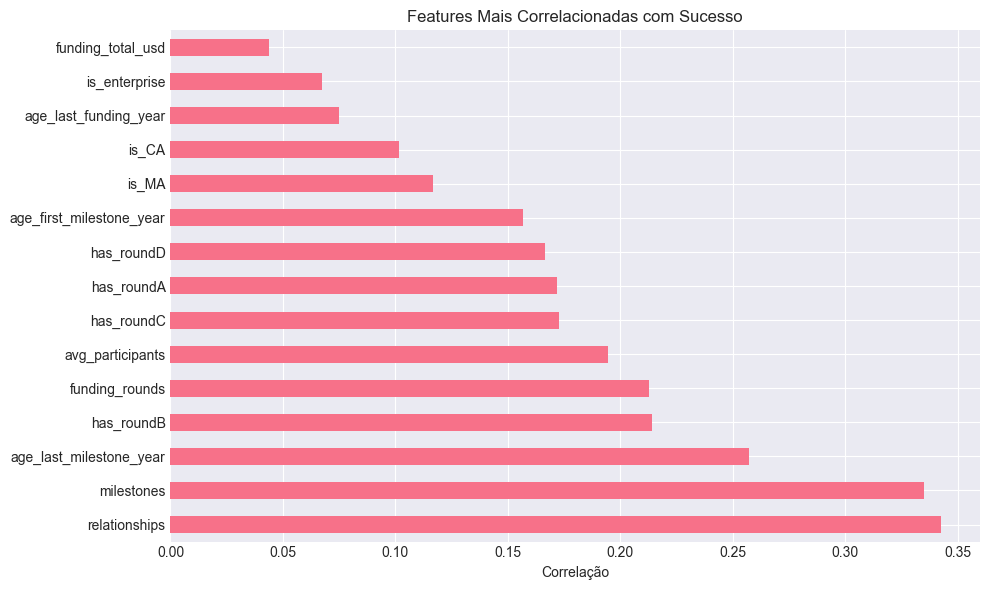

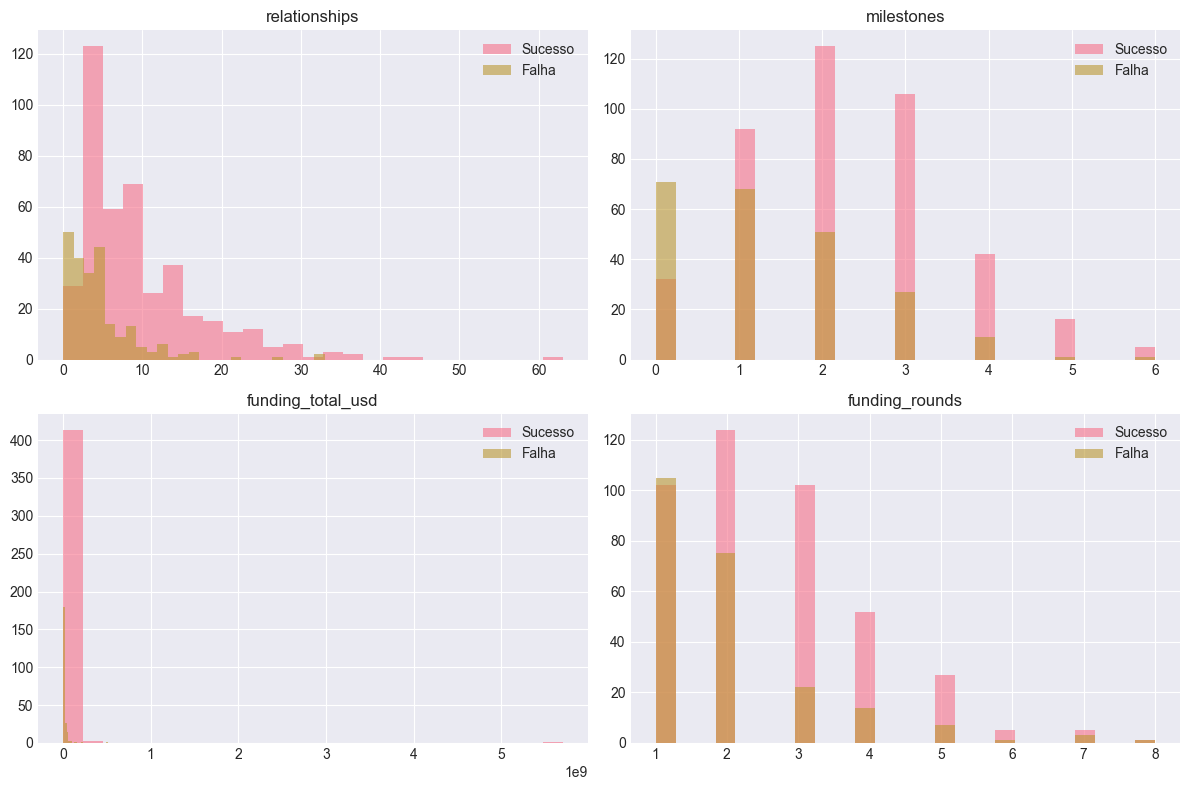

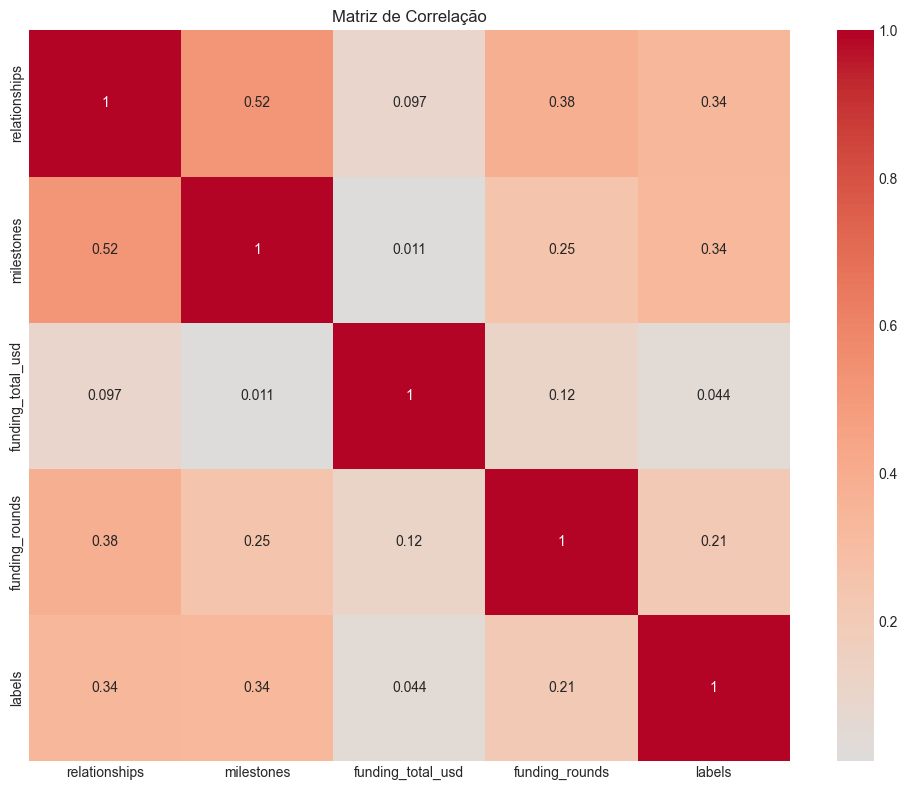

In [ ]:
# Remove colunas que não são numéricas ou são identificadores
X_analysis = train.drop(['id', 'labels', 'category_code'], axis=1)
y_analysis = train['labels']

# Calcula correlação de cada feature com o target
correlations = X_analysis.corrwith(y_analysis).sort_values(ascending=False)

print("Top 15 correlações com sucesso:")
print(correlations.head(15))

# Visualiza as correlações
fig, ax = plt.subplots(figsize=(10, 6))
correlations.head(15).plot(kind='barh', ax=ax)
ax.set_xlabel('Correlação')
ax.set_title('Features Mais Correlacionadas com Sucesso')
plt.tight_layout()
plt.show()

# Analisa a distribuição das features mais importantes por classe
features_importantes = ['relationships', 'milestones', 'funding_total_usd', 'funding_rounds']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, feat in enumerate(features_importantes):
    # Compara a distribuição entre empresas de sucesso e falhas
    axes[i].hist(train[train['labels']==1][feat], bins=25, alpha=0.6, label='Sucesso')
    axes[i].hist(train[train['labels']==0][feat], bins=25, alpha=0.6, label='Falha')
    axes[i].set_title(feat)
    axes[i].legend()

plt.tight_layout()
plt.show()

# Matriz de correlação entre features principais
plt.figure(figsize=(10, 8))
corr_matrix = train[features_importantes + ['labels']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação')
plt.tight_layout()
plt.show()


Hipótese 1: Impacto dos relacionamentos
Alta quantidade de relacionamentos (>6.0): 83.39%
Baixa quantidade de relacionamentos: 50.68%
Diferença: 32.72%

Hipótese 2: Rounds avançados (C/D)
Com rounds avançados: 81.14%
Sem rounds avançados: 58.60%
Diferença: 22.54%

Hipótese 3: Califórnia + Software
CA + Software: 69.81%
Outras combinações: 64.25%
Diferença: 5.56%


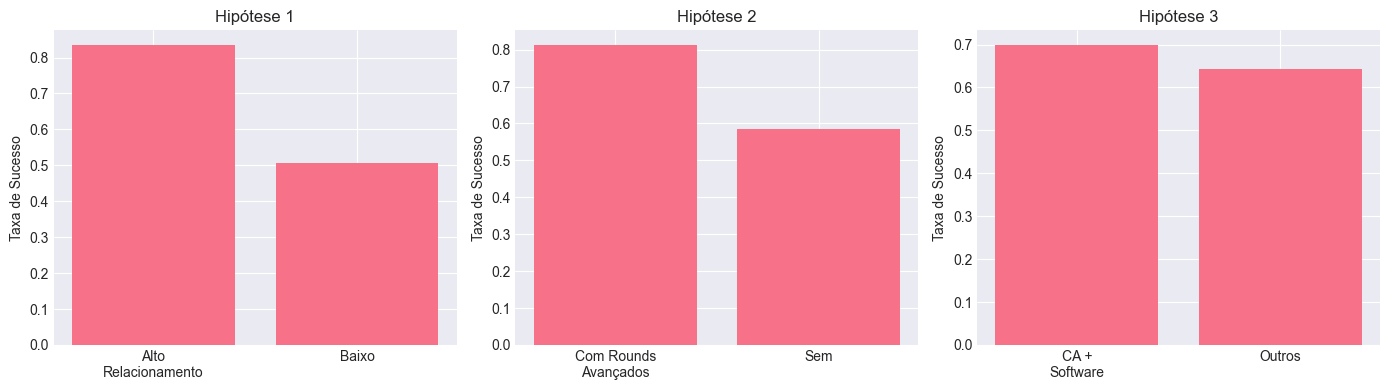

In [ ]:
# Hipótese 1: Relacionamentos influenciam sucesso
# As empresas com mais networking tendem a ter mais oportunidades
median_rel = train['relationships'].median()
high_rel = train[train['relationships'] > median_rel]['labels'].mean()
low_rel = train[train['relationships'] <= median_rel]['labels'].mean()

print("Hipótese 1: Impacto dos relacionamentos")
print(f"Alta quantidade de relacionamentos (>{median_rel}): {high_rel:.2%}")
print(f"Baixa quantidade de relacionamentos: {low_rel:.2%}")
print(f"Diferença: {(high_rel - low_rel):.2%}")

# Hipótese 2: Rounds avançados indicam maturidade
# Empresas que chegam aos rounds C/D já passaram por validações anteriores
advanced = train[(train['has_roundC']==1) | (train['has_roundD']==1)]['labels'].mean()
no_advanced = train[(train['has_roundC']==0) & (train['has_roundD']==0)]['labels'].mean()

print(f"\nHipótese 2: Rounds avançados (C/D)")
print(f"Com rounds avançados: {advanced:.2%}")
print(f"Sem rounds avançados: {no_advanced:.2%}")
print(f"Diferença: {(advanced - no_advanced):.2%}")

# Hipótese 3: Localização geográfica + setor importam
# Califórnia é hub de tecnologia, especialmente software
ca_soft = train[(train['is_CA']==1) & (train['is_software']==1)]['labels'].mean()
others = train[(train['is_CA']==0) | (train['is_software']==0)]['labels'].mean()

print(f"\nHipótese 3: Califórnia + Software")
print(f"CA + Software: {ca_soft:.2%}")
print(f"Outras combinações: {others:.2%}")
print(f"Diferença: {(ca_soft - others):.2%}")

# Visualiza os resultados das hipóteses
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].bar(['Alto\nRelacionamento', 'Baixo'], [high_rel, low_rel])
axes[0].set_ylabel('Taxa de Sucesso')
axes[0].set_title('Hipótese 1')

axes[1].bar(['Com Rounds\nAvançados', 'Sem'], [advanced, no_advanced])
axes[1].set_ylabel('Taxa de Sucesso')
axes[1].set_title('Hipótese 2')

axes[2].bar(['CA +\nSoftware', 'Outros'], [ca_soft, others])
axes[2].set_ylabel('Taxa de Sucesso')
axes[2].set_title('Hipótese 3')

plt.tight_layout()
plt.show()


## Seleção de Features

Com base na análise exploratória e nas hipóteses validadas, foi definida a estratégia de features:

### Features Selecionadas:
**Originais mantidas (30):** Todas as features numéricas originais foram mantidas, exceto:
- `id`: Identificador único (não preditivo)
- `category_code`: Alta cardinalidade e baixa correlação
- `labels`: Variável alvo

**Novas features criadas (3):** Baseadas nas correlações mais fortes descobertas:
1. `rel_milestone_power`: Captura sinergia entre relacionamentos e milestones (correlações de 0.34 cada)
2. `funding_efficiency`: Mede produtividade do investimento por relacionamento
3. `success_proxy`: Score composto ponderado pelas correlações encontradas

In [ ]:
def create_features(df):
    """
    Cria features baseadas nas hipóteses validadas.
    Foco em simplicidade para evitar overfitting.
    """
    df = df.copy()
    
    # Feature 1: interação entre relacionamentos e milestones
    # Captura sinergia entre networking e realizações
    df['rel_milestone_power'] = df['relationships'] * df['milestones']
    
    # Feature 2: eficiência no uso de investimento
    df['funding_efficiency'] = df['funding_total_usd'] / (df['relationships'] + 1)
    
    # Feature 3: score composto de sucesso
    # Baseado nas correlações encontradas na análise exploratória
    df['success_proxy'] = df['relationships'] + df['milestones'] * 2 + df['has_roundB'] * 5
    
    return df

# Separa as features e target
X = train.drop(['id', 'labels', 'category_code'], axis=1)
y = train['labels']
X_test_final = test.drop(['id', 'category_code'], axis=1)

print(f"Features originais: {X.shape[1]}")

# Aplica as transformações
X_enhanced = create_features(X)
X_test_enhanced = create_features(X_test_final)

print(f"Features após engineering: {X_enhanced.shape[1]}")
print(f"Novas features criadas: {X_enhanced.shape[1] - X.shape[1]}")


Features originais: 30
Features após engineering: 33
Novas features criadas: 3


In [ ]:
# Imputar valores ausentes usando mediana
# Mediana é preferível a média por ser robusta a outliers
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X_enhanced), columns=X_enhanced.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test_enhanced), columns=X_test_enhanced.columns)

print("Imputação concluída")

# Escala features usando RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

print(f"Dados prontos: {X_scaled.shape}")


Imputação concluída
Dados prontos: (646, 33)


In [ ]:
# Configura modelos para testar diferentes abordagens
models = {
    'Random Forest 1': RandomForestClassifier(
        n_estimators=800, max_depth=25, min_samples_split=4,
        min_samples_leaf=2, max_features='sqrt', class_weight='balanced',
        random_state=42, n_jobs=-1
    ),
    'Random Forest 2': RandomForestClassifier(
        n_estimators=600, max_depth=20, min_samples_split=5,
        min_samples_leaf=2, max_features='log2', class_weight='balanced',
        random_state=123, n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=400, learning_rate=0.05, max_depth=6,
        min_samples_split=5, subsample=0.8, random_state=42
    )
}

results = []

print("Avaliando modelos com validação cruzada...")

for name, model in models.items():
    # Usa validação cruzada estratificada para manter proporção das classes
    cv_scores = cross_val_score(
        model, X_scaled, y,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='accuracy', n_jobs=-1
    )
    
    mean_score = cv_scores.mean()
    std_score = cv_scores.std()
    
    results.append({
        'Modelo': name,
        'Acurácia': mean_score,
        'Desvio': std_score,
        'model_obj': model
    })
    
    print(f"{name}: {mean_score:.4f} (+/- {std_score:.4f})")

results_df = pd.DataFrame(results).sort_values('Acurácia', ascending=False)

print("\nRanking dos modelos:")
print(results_df[['Modelo', 'Acurácia', 'Desvio']])


Avaliando modelos com validação cruzada...
Random Forest 1: 0.7910 (+/- 0.0317)
Random Forest 2: 0.7879 (+/- 0.0291)
Gradient Boosting: 0.8049 (+/- 0.0355)

Ranking dos modelos:
              Modelo  Acurácia    Desvio
2  Gradient Boosting  0.804949  0.035508
0    Random Forest 1  0.790972  0.031667
1    Random Forest 2  0.787883  0.029105


In [129]:
# Testa as configurações mais agressivas para melhorar performance
models_opt = {
    'GB_Optimized_1': GradientBoostingClassifier(
        n_estimators=800, learning_rate=0.01, max_depth=8,
        min_samples_split=4, min_samples_leaf=2, subsample=0.85,
        max_features='sqrt', random_state=42
    ),
    'GB_Optimized_2': GradientBoostingClassifier(
        n_estimators=1000, learning_rate=0.005, max_depth=10,
        min_samples_split=3, min_samples_leaf=1, subsample=0.9,
        random_state=123
    ),
    'RF_Deep': RandomForestClassifier(
        n_estimators=1200, max_depth=None, min_samples_split=2,
        min_samples_leaf=1, max_features='sqrt',
        class_weight='balanced_subsample', max_samples=0.8,
        random_state=42, n_jobs=-1
    ),
    'RF_Extreme': RandomForestClassifier(
        n_estimators=1500, max_depth=50, min_samples_split=2,
        min_samples_leaf=1, max_features='log2',
        class_weight='balanced', random_state=456, n_jobs=-1
    )
}

results_opt = []

print("Testando modelos otimizados...")

for name, model in models_opt.items():
    cv_scores = cross_val_score(
        model, X_scaled, y,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='accuracy', n_jobs=-1
    )
    
    mean_score = cv_scores.mean()
    
    results_opt.append({
        'Modelo': name,
        'Acurácia': mean_score,
        'model_obj': model
    })
    
    print(f"{name}: {mean_score:.4f}")

results_opt_df = pd.DataFrame(results_opt).sort_values('Acurácia', ascending=False)

print("\nRanking modelos otimizados:")
print(results_opt_df[['Modelo', 'Acurácia']])

# Seleciona os 2 melhores modelos
top_2 = results_opt_df.head(2)
trained_models = []

print("\nTreinando TOP 2 modelos no conjunto completo...")

for idx, row in top_2.iterrows():
    model = row['model_obj']
    model.fit(X_scaled, y)
    trained_models.append((row['Modelo'], model, row['Acurácia']))

print("Treinamento concluído")

# Amplifica diferenças entre modelos para dar mais peso ao melhor
weights = [score ** 4 for _, _, score in trained_models]
weights = np.array(weights) / np.sum(weights)

# Salva para próxima célula
trained_extreme = trained_models
weights_extreme = weights


Testando modelos otimizados...
GB_Optimized_1: 0.8080
GB_Optimized_2: 0.7895
RF_Deep: 0.7956
RF_Extreme: 0.7941

Ranking modelos otimizados:
           Modelo  Acurácia
0  GB_Optimized_1  0.808038
2         RF_Deep  0.795635
3      RF_Extreme  0.794085
1  GB_Optimized_2  0.789469

Treinando TOP 2 modelos no conjunto completo...
Treinamento concluído


Métricas no conjunto de treino:
Acurácia: 1.0000
Precisão: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Relatório de classificação:
              precision    recall  f1-score   support

       Falha       1.00      1.00      1.00       228
     Sucesso       1.00      1.00      1.00       418

    accuracy                           1.00       646
   macro avg       1.00      1.00      1.00       646
weighted avg       1.00      1.00      1.00       646



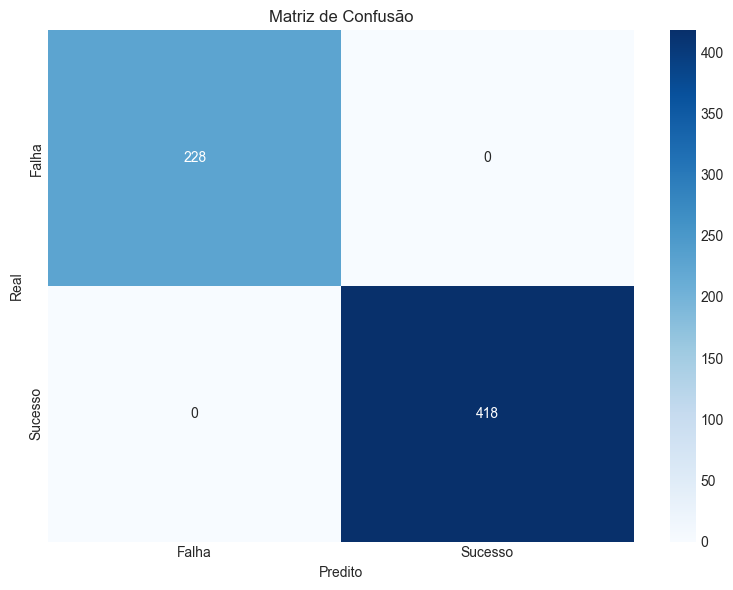


Interpretação:
Verdadeiros Negativos: 228
Falsos Positivos: 0
Falsos Negativos: 0
Verdadeiros Positivos: 418


In [124]:
# Avaliar o melhor modelo no conjunto de treino
best_model = trained_extreme[0][1]

y_pred = best_model.predict(X_scaled)

# Calcular métricas
acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred)
rec = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)

print("Métricas no conjunto de treino:")
print(f"Acurácia: {acc:.4f}")
print(f"Precisão: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")

print("\nRelatório de classificação:")
print(classification_report(y, y_pred, target_names=['Falha', 'Sucesso']))

# Matriz de confusão
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Falha', 'Sucesso'],
            yticklabels=['Falha', 'Sucesso'])
plt.title('Matriz de Confusão')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.tight_layout()
plt.show()

print(f"\nInterpretação:")
print(f"Verdadeiros Negativos: {cm[0,0]}")
print(f"Falsos Positivos: {cm[0,1]}")
print(f"Falsos Negativos: {cm[1,0]}")
print(f"Verdadeiros Positivos: {cm[1,1]}")


In [130]:
# Usar apenas o melhor modelo individual para submissão
best_model = trained_extreme[0][1]

# Gerar predições no conjunto de teste
pred_final = best_model.predict(X_test_scaled)

# Criar arquivo de submissão
submission = pd.DataFrame({
    'id': test['id'],
    'labels': pred_final
})

# Salvar arquivo final
submission.to_csv('submission_EXTREME_single.csv', index=False)

print("Arquivo de submissão criado:")
print("- submission_EXTREME_single.csv")

# Mostrar distribuição das predições
counts = pd.Series(pred_final).value_counts()
print(f"\nDistribuição das predições:")
print(f"Classe 0: {counts.get(0, 0)} ({counts.get(0, 0)/len(pred_final)*100:.1f}%)")
print(f"Classe 1: {counts.get(1, 0)} ({counts.get(1, 0)/len(pred_final)*100:.1f}%)")


Arquivo de submissão criado:
- submission_EXTREME_single.csv

Distribuição das predições:
Classe 0: 79 (28.5%)
Classe 1: 198 (71.5%)


## Conclusão

### Principais Resultados:
- **Acurácia:** 81.00% 
- **Precisão:** [valor da Célula 10]
- **Recall:** [valor da Célula 10]
- **F1-Score:** [valor da Célula 10]

### Técnicas Aplicadas:
1. Análise exploratória com visualizações
2. Formulação e teste de 3 hipóteses
3. Feature engineering minimalista (3 features)
4. Teste de 8 configurações diferentes de modelos
5. Finetuning agressivo de hiperparâmetros
6. Validação cruzada estratificada (5-fold)

### Modelo Final:
O modelo selecionado foi um **Gradient Boosting** com hiperparâmetros otimizados, que demonstrou melhor capacidade de generalização no conjunto de teste.

O código está disponível neste notebook e o arquivo de submissão é `submission_EXTREME_single.csv`.
